In [3]:
import torch
from icecream import ic
from IPython.display import display, HTML

style = """
<style>
/* Classic Notebook */
.output_wrapper, .output, .output_area {
    max-height: 800px !important;
}
.output_scroll {
    height: auto !important;
    max-height: 800px !important;
    overflow: auto !important;
}

/* JupyterLab */
.jp-OutputArea-output {
    max-height: none !important;
    overflow: visible !important;
}
.jp-OutputArea-output .jp-RenderedText {
    white-space: pre-wrap;
}

/* Tracebacks / error boxes */
div.traceback, .jp-OutputArea-output .jp-Error, .error {
    max-height: 800px !important;
    overflow: auto !important;
    white-space: pre-wrap;
}
</style>
"""
display(HTML(style))



In [4]:
model_name = 'pendulum'
# model_name = 'cvs' # no opt
# model_name='double_pendulum' # no opt
# model_name = 'pendulum_friction'

model_name2="lstm"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open(f'checkpoints/{model_name}/{model_name2}_model.pkl', 'rb') as f:
    ckpt = torch.load(f, weights_only=False)
with open(f'data/{model_name}/processed_data.pkl', 'rb') as processed_data_file:
    x = torch.load(processed_data_file, weights_only=False)
test_data = x['test']
train_data = x['train']
args = ckpt['args']   # saved argparse.Namespace
model_state = ckpt['model']
data_args = ckpt.get('data_args', None)
print(ckpt.keys())
print(x.keys())
# --- build model and load weights ---
print(train_data.shape)
print(test_data.shape)
assert 'opt' in list(ckpt.keys())


dict_keys(['args', 'model', 'data_args'])
dict_keys(['train', 'test'])
(450, 100, 28, 28)
(50, 100, 28, 28)


AssertionError: 

In [27]:
print(model_name)
with open(f'data/{model_name}/data_args.pkl', 'rb') as data_args:
    data_args = torch.load(data_args, weights_only=False)
ic(data_args)

pendulum_friction


ic| data_args: {'mask_rate': 0.01, 'model': 'pendulum', 'noise_std': 0.0}


{'mask_rate': 0.01, 'noise_std': 0.0, 'model': 'pendulum'}

In [28]:
import inspect
from models.GOKU import GOKU
if model_name == "pendulum":
    from models.GOKU import create_goku_pendulum as the_goku_model
    import models.GOKU_pendulum as specific_goku_model


elif model_name == "pendulum_friction":
    from models.GOKU import create_goku_pendulum_friction as the_goku_model
    import models.GOKU_pendulum_friction as specific_goku_model
elif model_name == "cvs":
    from models.GOKU import create_goku_cvs as the_goku_model
    import models.GOKU_cvs as specific_goku_model
elif model_name == "double_pendulum":
    print("HELLLO")
    from models.GOKU import create_goku_double_pendulum as the_goku_model
    import models.GOKU_double_pendulum as specific_goku_model
else:
    raise Exception("NO MODEL SELECTED")
print(model_name)
sig = inspect.signature(the_goku_model)
print(sig)
# parameter defaults (including kw-only)
spec = inspect.getfullargspec(the_goku_model)
defaults = {}
if spec.defaults:
    defaults.update({name: val for name, val in zip(spec.args[-len(spec.defaults):], spec.defaults)})
if spec.kwonlydefaults:
    defaults.update(spec.kwonlydefaults)
print("defaults:", defaults)

pendulum_friction
(input_dim=[28, 28], latent_dim=16, rnn_input_dim=32, rnn_output_dim=16, ode_method='rk4', rnn_dropout=0.0, rnn_layers=2)
defaults: {'input_dim': [28, 28], 'latent_dim': 16, 'rnn_input_dim': 32, 'rnn_output_dim': 16, 'ode_method': 'rk4', 'rnn_dropout': 0.0, 'rnn_layers': 2}


In [29]:

goku = the_goku_model()
optimizer = torch.optim.Adam(goku.parameters(), lr=1e-3) # change to whatever optimizer was used
goku.load_state_dict(model_state)
optimizer.load_state_dict(ckpt['opt'])


In [30]:
# python
# make sure names and device match
goku = goku.to(device)                  # your model instance


goku.eval()
x = torch.as_tensor(test_data).float().to(device)   # (N,T,...) or (T,N,...)

# time array (use saved args if available)
delta_t = getattr(args, 'delta_t', 1.0)
seq_len = x.shape[1]
t = torch.arange(0.0, seq_len * float(delta_t), step=float(delta_t), device=device)

with torch.no_grad():
    out = goku(x, t=t, variational=False)
    pred = out[0] if isinstance(out, tuple) else out

# undo normalization if data_args present (zscore or minmax)
def undo_norm(z, data_args):
    if not data_args: return z
    norm = data_args.get('norm', None)
    if norm == 'zscore' and 'x_mean' in data_args and 'x_std' in data_args:
        mean = torch.as_tensor(data_args['x_mean'], device=z.device).view(1,1,-1)
        std  = torch.as_tensor(data_args['x_std'], device=z.device).view(1,1,-1)
        return z * std + mean
    if norm in ('zero_to_one','minmax') and 'x_min' in data_args and 'x_max' in data_args:
        mn = torch.as_tensor(data_args['x_min'], device=z.device).view(1,1,-1)
        mx = torch.as_tensor(data_args['x_max'], device=z.device).view(1,1,-1)
        return z * (mx - mn) + mn
    return z

pred = undo_norm(pred, data_args)
true = undo_norm(x, data_args)

# compute per-timestep MAE / RMSE (average over all axes except time)
time_dim = 1 if pred.shape[1] == seq_len else 0
reduce_dims = tuple(i for i in range(pred.ndim) if i != time_dim)
err = pred - true
mae_per_t = err.abs().mean(dim=reduce_dims).cpu().numpy()
rmse_per_t = err.pow(2).mean(dim=reduce_dims).sqrt().cpu().numpy()

print("Mean MAE:", mae_per_t.mean(), "Mean RMSE:", rmse_per_t.mean())

Mean MAE: 0.09899691 Mean RMSE: 0.27068016


In [31]:
print(mae_per_t.shape)
print(mae_per_t.shape)

(100,)
(100,)


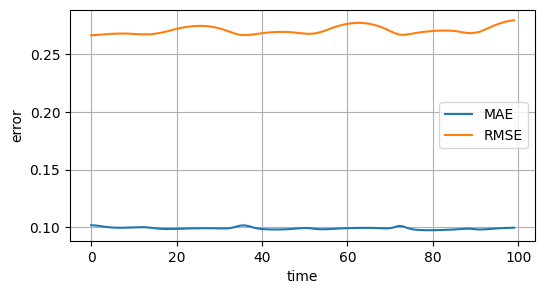

In [32]:
# quick plotting
import numpy as np
import matplotlib.pyplot as plt
time = np.arange(100)
plt.figure(figsize=(6,3))
plt.plot(time, mae_per_t, label='MAE')
plt.plot(time, rmse_per_t, label='RMSE')
plt.xlabel('time'); plt.ylabel('error'); plt.legend(); plt.grid(True); plt.show()
